In [1]:
import pandas as pd
from prophet import Prophet

In [2]:
def read_data(f, cols, sep='[;,|_]', engine='python'):
    df = pd.read_csv(f, sep=sep, engine=engine, header=None)
    df.columns=cols
    return df

In [3]:
df = read_data('/Users/meghagodwal/Desktop/project 2_DS/SN_y_tot_V2.0.csv', 
              ['Year','y','Yearly_std','No_observation','Provisonal_indicator'])
df.head()

,Year,y,Yearly_std,No_observation,Provisonal_indicator
0,1700.5,8.3,-1.0,-1,1
1,1701.5,18.3,-1.0,-1,1
2,1702.5,26.7,-1.0,-1,1
3,1703.5,38.3,-1.0,-1,1
4,1704.5,60.0,-1.0,-1,1


### Prep and clean yearly dataset

In [4]:
def year_data(row):
    return str(row['Year']).split('.',1)[0] + "-01-01"

In [5]:
df['ds'] = df.apply(year_data,axis=1)
df

,Year,y,Yearly_std,No_observation,Provisonal_indicator,ds
0,1700.5,8.3,-1.0,-1,1,1700-01-01
1,1701.5,18.3,-1.0,-1,1,1701-01-01
2,1702.5,26.7,-1.0,-1,1,1702-01-01
3,1703.5,38.3,-1.0,-1,1,1703-01-01
4,1704.5,60.0,-1.0,-1,1,1704-01-01
...,...,...,...,...,...,...
316,2016.5,39.8,3.9,9940,1,2016-01-01
317,2017.5,21.7,2.5,11444,1,2017-01-01
318,2018.5,7.0,1.1,12611,1,2018-01-01
319,2019.5,3.6,0.5,12884,1,2019-01-01


#### Changing the year column to datetime 

In [6]:
df1=df.drop(columns=['Year','Yearly_std','No_observation','Provisonal_indicator'])
df1

,y,ds
0,8.3,1700-01-01
1,18.3,1701-01-01
2,26.7,1702-01-01
3,38.3,1703-01-01
4,60.0,1704-01-01
...,...,...
316,39.8,2016-01-01
317,21.7,2017-01-01
318,7.0,2018-01-01
319,3.6,2019-01-01


#### Dropping few rows because of overflow error

In [24]:
df2 = df1.drop(df1.index[:50], axis = 0)
df2

,y,ds
50,139.0,1750-01-01
51,79.5,1751-01-01
52,79.7,1752-01-01
53,51.2,1753-01-01
54,20.3,1754-01-01
...,...,...
316,39.8,2016-01-01
317,21.7,2017-01-01
318,7.0,2018-01-01
319,3.6,2019-01-01


### Fitting the model

In [25]:
model = Prophet()
model.fit(df2)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [26]:
future_yearly_with_outlier = model.make_future_dataframe(periods=0, freq='y', include_history = True)
forecast_yearly_with_outlier = model.predict(future_yearly_with_outlier)
forecast_yearly_with_outlier[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
266,2016-01-01,85.246920,6.550429,164.885528
267,2017-01-01,80.870321,-1.126999,156.639208
268,2018-01-01,82.264637,0.892857,155.233409
269,2019-01-01,83.699865,4.998904,163.116107
270,2020-01-01,85.174218,0.733172,166.263959


## Outlier detectection and removal

In [27]:
def remove_outliers(forecast, df):
    # detect outliers
    forecast["outlier"] = 0
    forecast["y"] = df["y"].reset_index(drop = True)
    forecast.loc[(forecast['y'] > forecast['yhat_upper']+5), 'outlier'] = -1
    forecast.loc[(forecast['y'] < forecast['yhat_lower']-5), 'outlier'] = -1
    print("Outliers: ", len(forecast[forecast['outlier'] == -1]))
    print("Total: ", len(df))
    print("Remaining: ", (len(df)-len(forecast[forecast['outlier'] == -1])))
    
    # remove outliers
    forecast = forecast[forecast['outlier'] == 0].reset_index(drop = True)
    return forecast

In [28]:
df_yearly_without_outlier = remove_outliers(forecast_yearly_with_outlier, df2)

Outliers:  35
Total:  271
Remaining:  236


### Refitting the data

In [29]:
model = Prophet()
model.fit(df_yearly_without_outlier)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [30]:
future_yearly_without_outlier = model.make_future_dataframe(periods=0, freq='y', include_history = True)
forecast_yearly_without_outlier = model.predict(future_yearly_without_outlier)
forecast_yearly_without_outlier[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
231,2016-01-01,64.247886,9.471427,118.027453
232,2017-01-01,63.965104,8.586290,122.594339
233,2018-01-01,64.001908,8.252992,122.988404
234,2019-01-01,64.102590,3.640900,123.835102
235,2020-01-01,64.267005,6.981214,120.626130


# Linear Model

In [114]:
m = Prophet(daily_seasonality = False, yearly_seasonality = True, weekly_seasonality = False,
            seasonality_mode = 'additive',
            n_changepoints = 25,
            interval_width = 1.0,
            changepoint_range = 0.8,
            changepoint_prior_scale = 2.0,
            seasonality_prior_scale= 20.0 )

model = m.fit(df_yearly_without_outlier)

## 1 year forecast

In [115]:
future_1 = model.make_future_dataframe(periods = 1, freq='y')

In [116]:
forecast_1 = model.predict(future_1)
forecast_1.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1750-01-01,211.176115,-40.637257,243.949890,211.176115,211.176115,-128.863346,-128.863346,-128.863346,-128.863346,-128.863346,-128.863346,0.0,0.0,0.0,82.312769
1,1751-01-01,210.753585,-50.237360,206.927986,210.753585,210.753585,-134.307887,-134.307887,-134.307887,-134.307887,-134.307887,-134.307887,0.0,0.0,0.0,76.445699
2,1752-01-01,210.331056,-73.103765,256.440433,210.331056,210.331056,-138.764435,-138.764435,-138.764435,-138.764435,-138.764435,-138.764435,0.0,0.0,0.0,71.566621
3,1753-01-01,209.907370,-37.656571,246.468413,209.907370,209.907370,-122.439904,-122.439904,-122.439904,-122.439904,-122.439904,-122.439904,0.0,0.0,0.0,87.467466
4,1754-01-01,209.484841,-83.363817,223.695281,209.484841,209.484841,-128.863346,-128.863346,-128.863346,-128.863346,-128.863346,-128.863346,0.0,0.0,0.0,80.621495


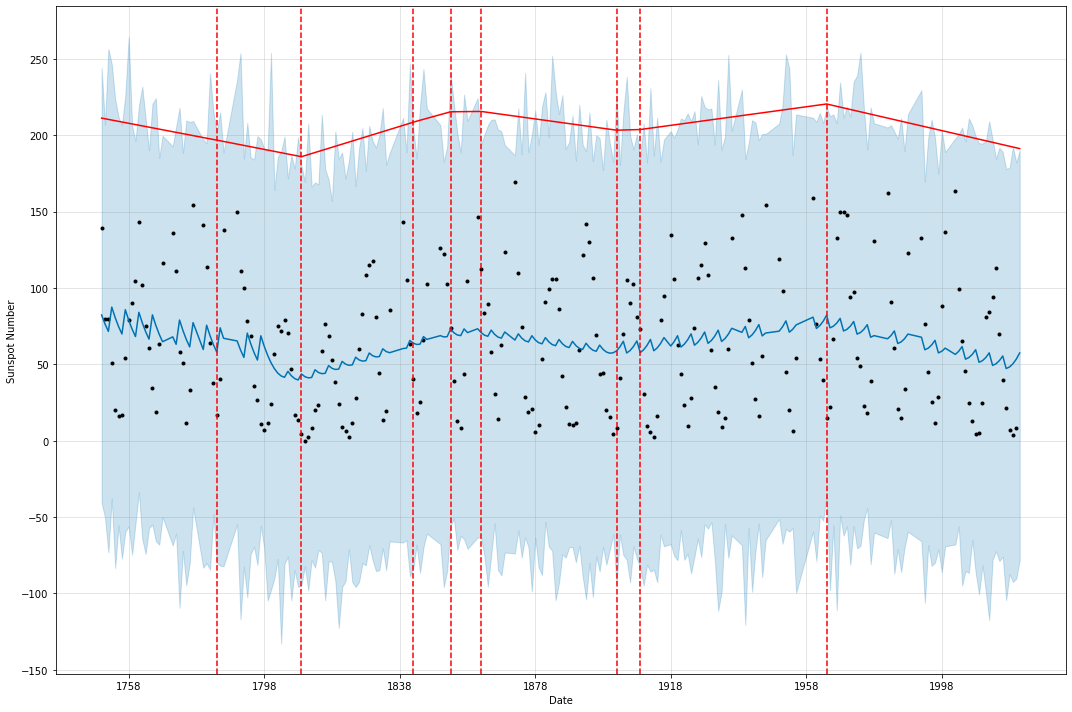

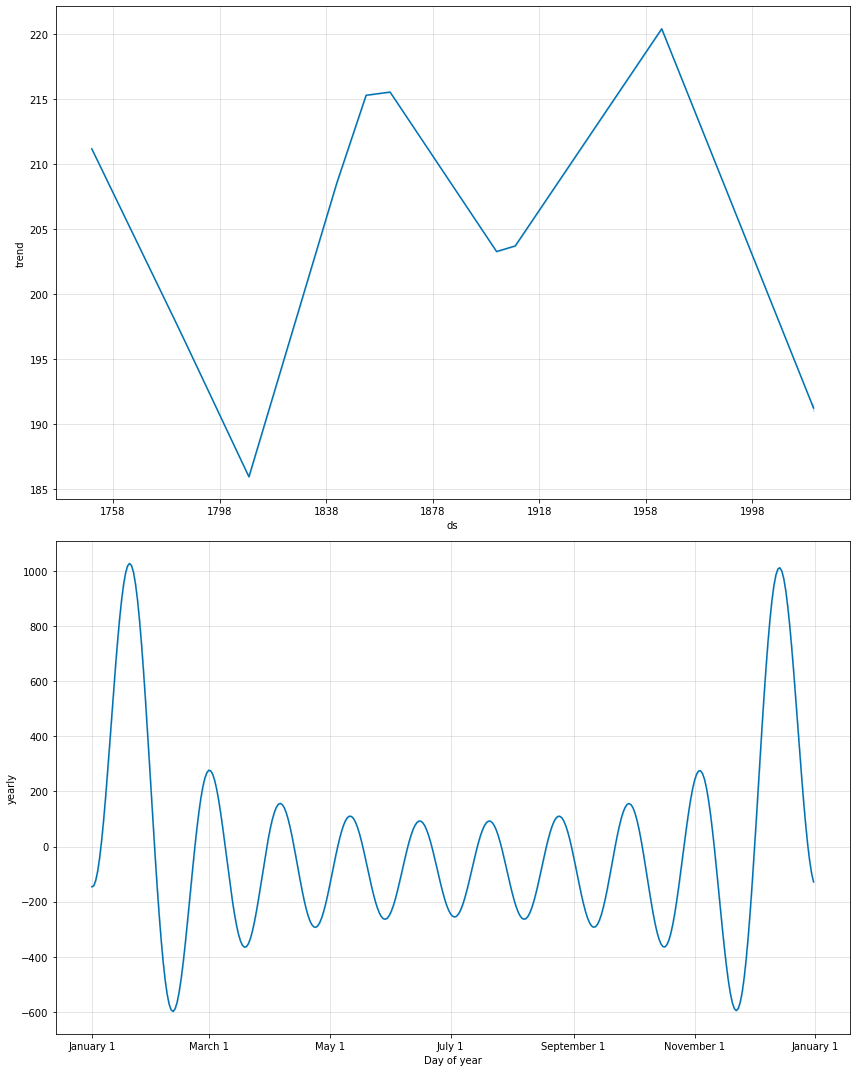

In [117]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast_1, xlabel = "Date", ylabel = "Sunspot Number", figsize = (15,10))
a= add_changepoints_to_plot(fig.gca(),model,forecast_1)
fig1=model.plot_components(forecast_1, figsize=(12,15))

### Cross Validation and Performance Metrics

In [118]:
from prophet.diagnostics import cross_validation
df_yearly_cv = cross_validation(model, initial='95000 days', period='150 days', horizon = '365 days', parallel = 'processes')

INFO:prophet:Making 22 forecasts with cutoffs between 2010-05-18 00:00:00 and 2019-01-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb0afc962b0>


In [119]:
from prophet.diagnostics import performance_metrics
df_yearly_perf = performance_metrics(df_yearly_cv)
df_yearly_perf.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,39 days,784.369428,28.006596,21.732507,0.936920,0.936920,0.505840,1.0
1,59 days,591.972562,24.330486,19.117183,0.210875,0.210875,0.252115,1.0
2,78 days,803.254507,28.341745,27.561063,0.311412,0.311412,0.371098,1.0
3,85 days,1526.743466,39.073565,36.042929,3.781887,3.781887,0.934039,1.0
4,104 days,1753.211070,41.871363,40.499034,4.027430,4.027430,1.057889,1.0


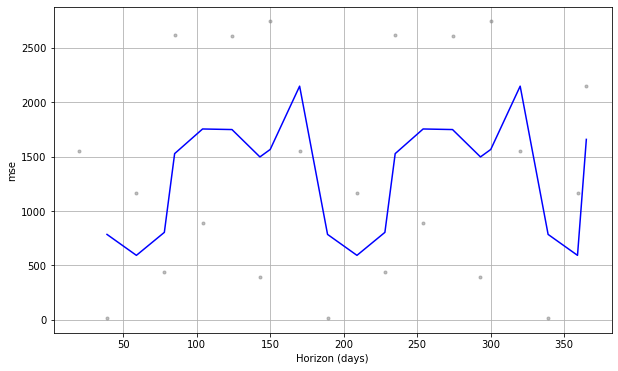

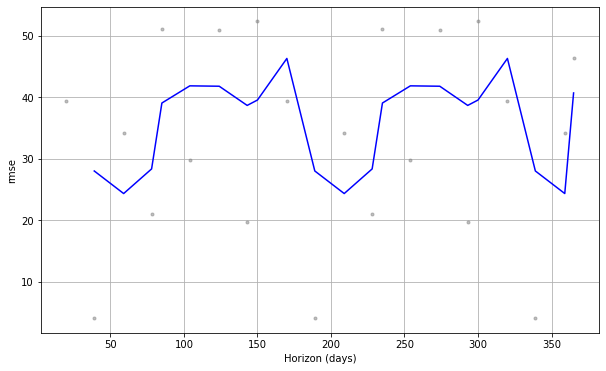

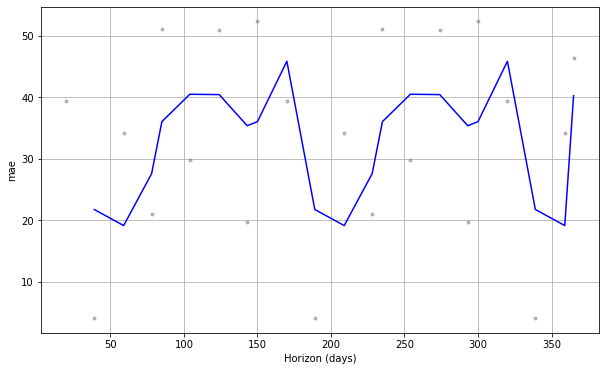

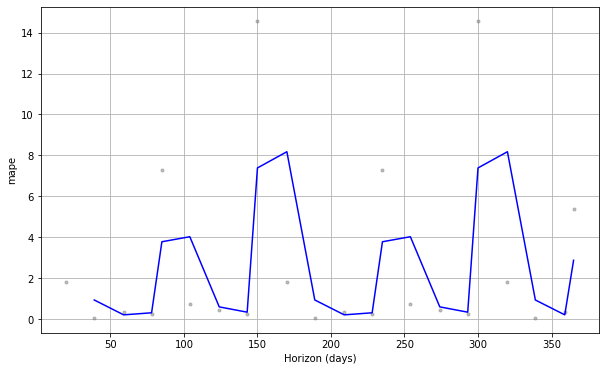

In [120]:
from fbprophet.plot import plot_cross_validation_metric

plt_mse = plot_cross_validation_metric(df_yearly_cv, metric='mse')

plt_rmse = plot_cross_validation_metric(df_yearly_cv, metric='rmse')

plt_mae = plot_cross_validation_metric(df_yearly_cv, metric='mae')

plt_mape = plot_cross_validation_metric(df_yearly_cv, metric='mape')

In [121]:
from sklearn.metrics import r2_score
r2_yearly= r2_score(df_yearly_cv['y'], df_yearly_cv['yhat'])
r2_yearly

0.03882342385492732

## 10 year forecast

In [122]:
future_10 = model.make_future_dataframe(periods = 10, freq='y')

In [123]:
forecast_10 = model.predict(future_10)
forecast_10.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1750-01-01,211.176115,-74.895456,234.201547,211.176115,211.176115,-128.863346,-128.863346,-128.863346,-128.863346,-128.863346,-128.863346,0.0,0.0,0.0,82.312769
1,1751-01-01,210.753585,-65.765845,217.332266,210.753585,210.753585,-134.307887,-134.307887,-134.307887,-134.307887,-134.307887,-134.307887,0.0,0.0,0.0,76.445699
2,1752-01-01,210.331056,-56.656625,195.131431,210.331056,210.331056,-138.764435,-138.764435,-138.764435,-138.764435,-138.764435,-138.764435,0.0,0.0,0.0,71.566621
3,1753-01-01,209.907370,-47.646335,268.484756,209.907370,209.907370,-122.439904,-122.439904,-122.439904,-122.439904,-122.439904,-122.439904,0.0,0.0,0.0,87.467466
4,1754-01-01,209.484841,-57.015542,237.268341,209.484841,209.484841,-128.863346,-128.863346,-128.863346,-128.863346,-128.863346,-128.863346,0.0,0.0,0.0,80.621495


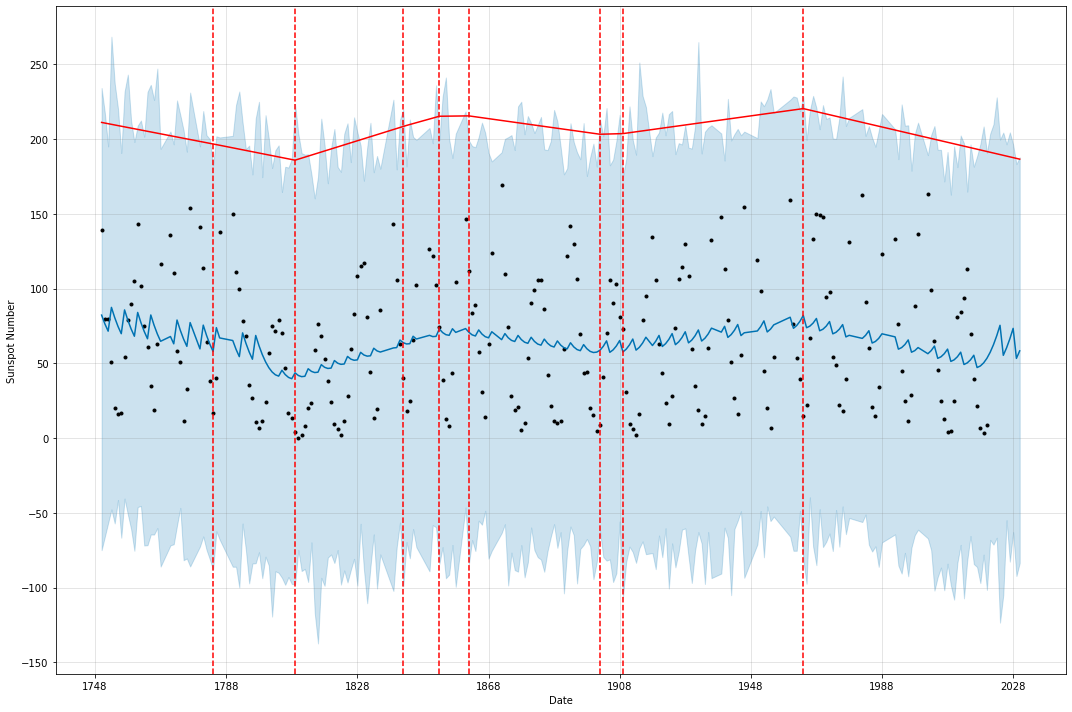

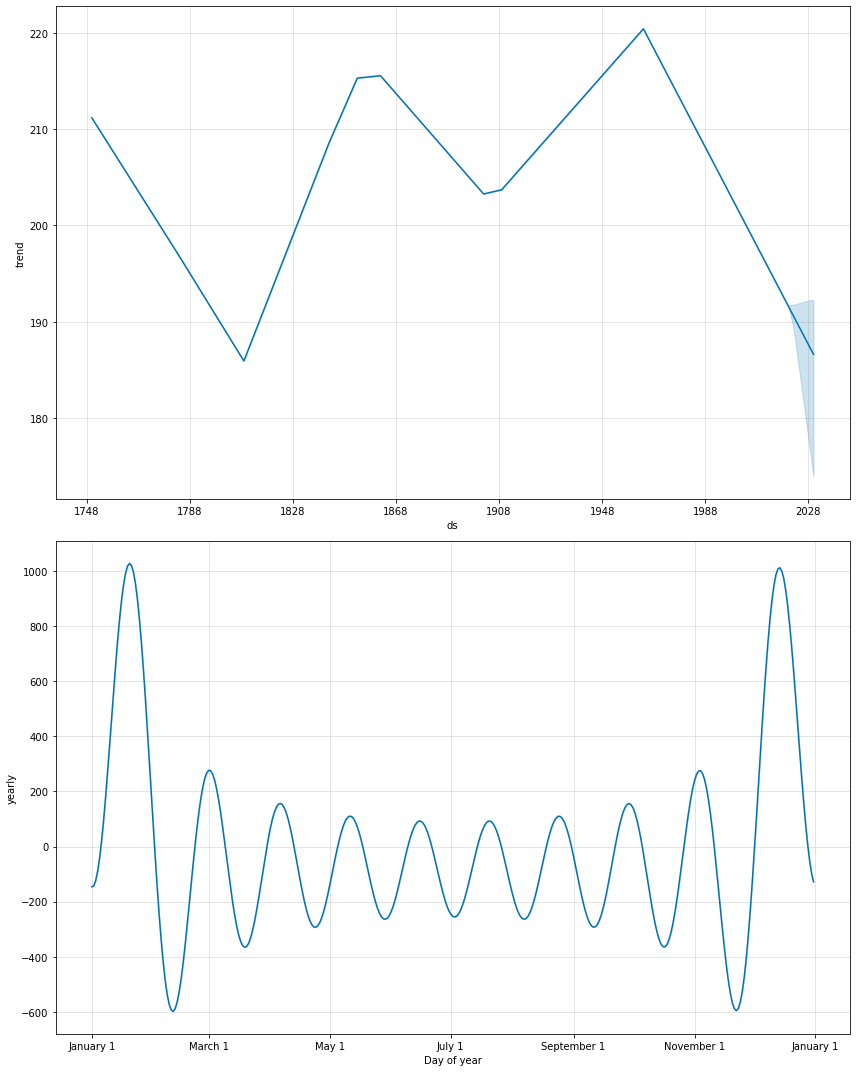

In [124]:
fig = model.plot(forecast_10, xlabel = "Date", ylabel = "Sunspot Number", figsize = (15,10))
a= add_changepoints_to_plot(fig.gca(),model,forecast_10)
fig1=model.plot_components(forecast_10, figsize=(12,15))

### Cross Validation and Performance Metrics

In [125]:
df_10_yearly_cv = cross_validation(model, initial='60000 days', period='200 days', horizon = '1365 days', parallel = 'processes')

INFO:prophet:Making 178 forecasts with cutoffs between 1914-07-30 00:00:00 and 2016-04-06 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb0afe5fb50>


In [126]:
df_10_yearly_perf = performance_metrics(df_10_yearly_cv)
df_10_yearly_perf.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,138 days,2407.237807,49.063610,42.090431,1.023414,0.511020,0.611005,1.0
1,139 days,2348.166049,48.457879,41.284121,1.015866,0.505360,0.600616,1.0
2,146 days,2350.465651,48.481601,41.316893,1.025488,0.516572,0.603787,1.0
3,147 days,2430.778035,49.302921,42.343257,1.157369,0.530801,0.638000,1.0
4,148 days,2452.728286,49.525027,42.617925,1.332879,0.538443,0.652382,1.0


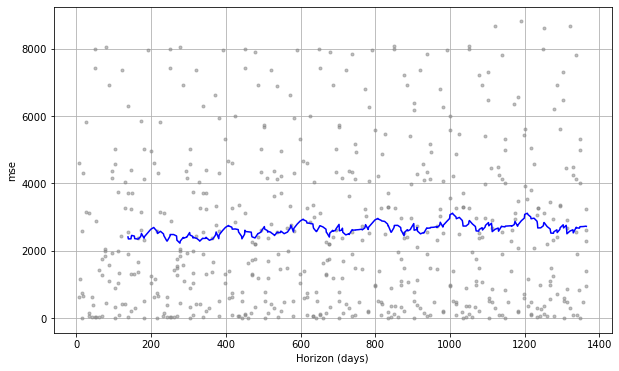

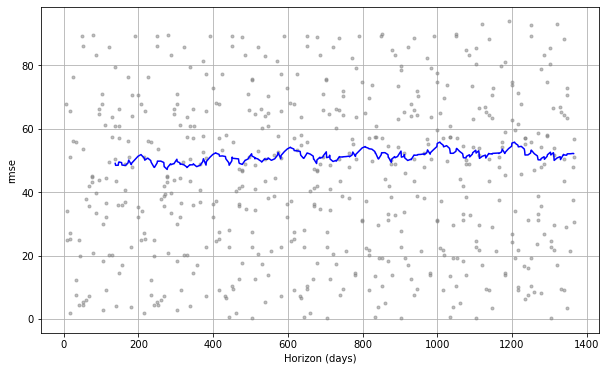

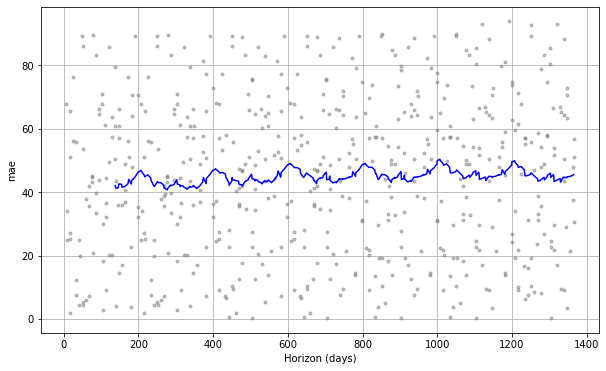

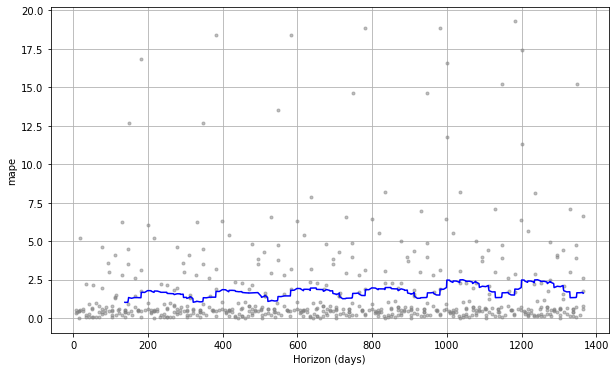

In [127]:
plt_mse = plot_cross_validation_metric(df_10_yearly_cv, metric='mse')

plt_rmse = plot_cross_validation_metric(df_10_yearly_cv, metric='rmse')

plt_mae = plot_cross_validation_metric(df_10_yearly_cv, metric='mae')

plt_mape = plot_cross_validation_metric(df_10_yearly_cv, metric='mape')

In [128]:
r2_10_yearly= r2_score(df_10_yearly_cv['y'], df_10_yearly_cv['yhat'])
print("R2 Square :")
r2_10_yearly

R2 Square :


-0.17685071998333068

## 20 year forecast

In [129]:
future_20 = model.make_future_dataframe(periods = 20, freq='y')
forecast_20 = model.predict(future_20)
forecast_20.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1750-01-01,211.176115,-43.547956,214.326617,211.176115,211.176115,-128.863346,-128.863346,-128.863346,-128.863346,-128.863346,-128.863346,0.0,0.0,0.0,82.312769
1,1751-01-01,210.753585,-85.320567,235.329653,210.753585,210.753585,-134.307887,-134.307887,-134.307887,-134.307887,-134.307887,-134.307887,0.0,0.0,0.0,76.445699
2,1752-01-01,210.331056,-75.705544,214.041315,210.331056,210.331056,-138.764435,-138.764435,-138.764435,-138.764435,-138.764435,-138.764435,0.0,0.0,0.0,71.566621
3,1753-01-01,209.907370,-46.010860,209.067632,209.907370,209.907370,-122.439904,-122.439904,-122.439904,-122.439904,-122.439904,-122.439904,0.0,0.0,0.0,87.467466
4,1754-01-01,209.484841,-34.718301,254.066494,209.484841,209.484841,-128.863346,-128.863346,-128.863346,-128.863346,-128.863346,-128.863346,0.0,0.0,0.0,80.621495


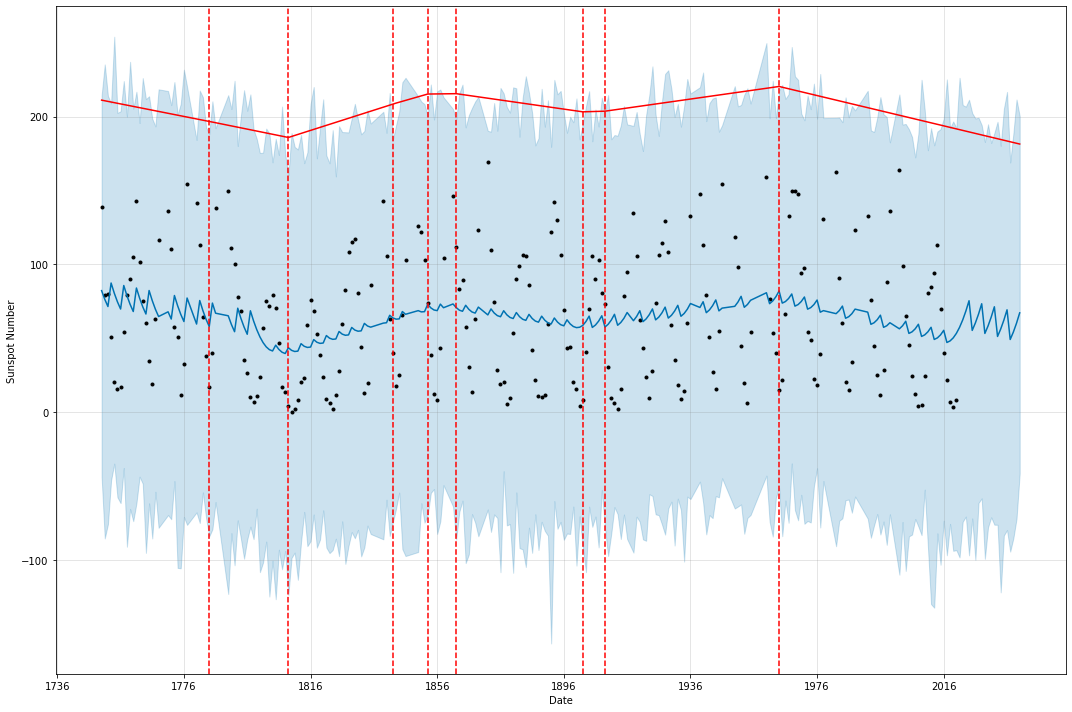

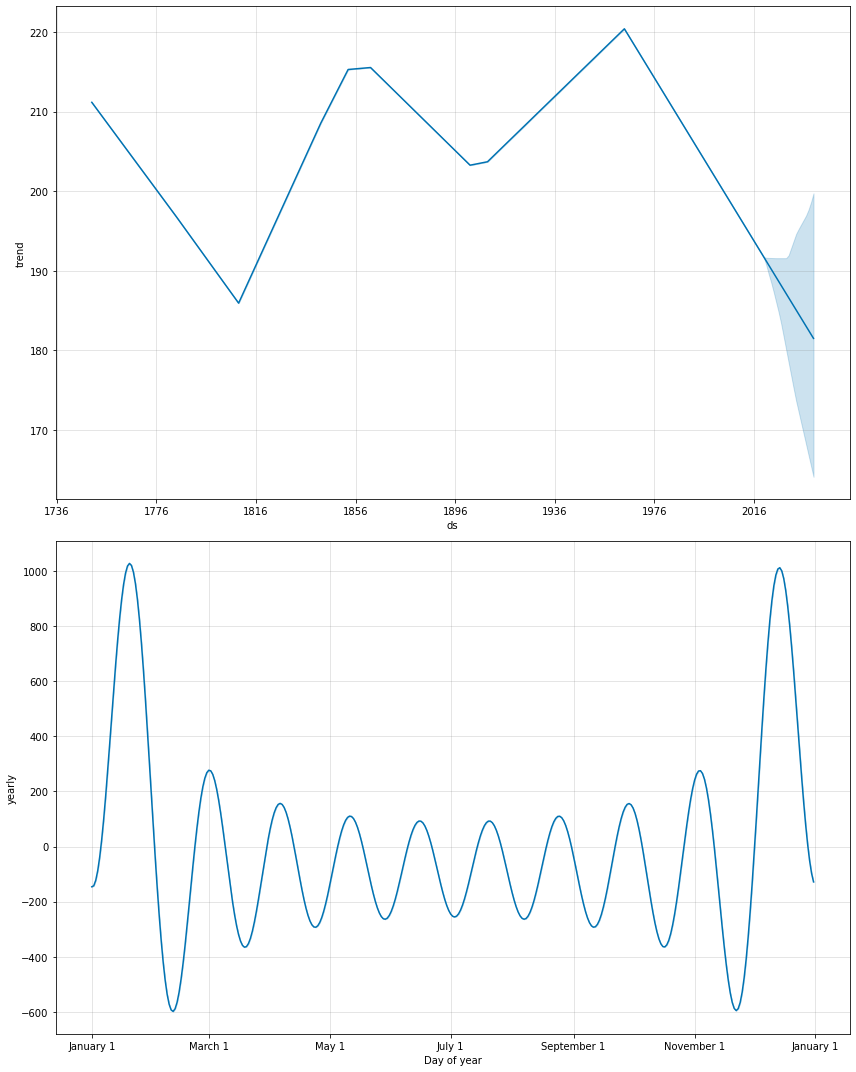

In [130]:
fig = model.plot(forecast_20, xlabel = "Date", ylabel = "Sunspot Number", figsize = (15,10))
a= add_changepoints_to_plot(fig.gca(),model,forecast_20)
fig1=model.plot_components(forecast_20, figsize=(12,15))

### Cross Validation and Performance Metrics

In [131]:
df_20_yearly_cv = cross_validation(model, initial='55000 days', period='350 days', horizon = '765 days', parallel = 'processes')

INFO:prophet:Making 102 forecasts with cutoffs between 1901-04-29 00:00:00 and 2017-11-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb0b124d5b0>


In [132]:
df_20_yearly_perf = performance_metrics(df_20_yearly_cv)
df_20_yearly_perf.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,35 days,2462.390526,49.622480,47.186933,2.770424,2.523413,1.003660,1.0
1,49 days,2517.877237,50.178454,47.973332,3.099931,2.911115,1.051461,1.0
2,65 days,2569.788583,50.693082,48.723127,3.973738,2.997313,1.108879,1.0
3,80 days,2556.821722,50.565025,48.649013,4.015782,2.997313,1.127663,1.0
4,95 days,2561.100921,50.607321,48.834873,3.992984,2.997313,1.129222,1.0


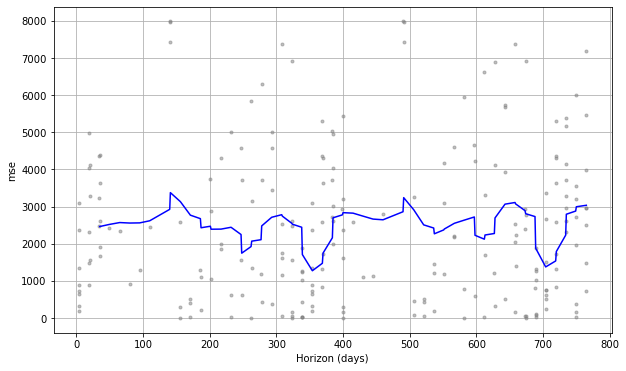

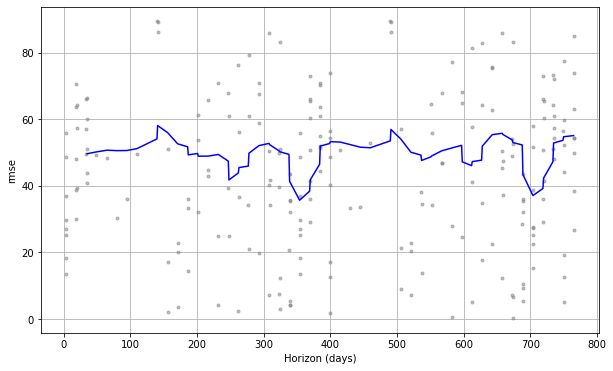

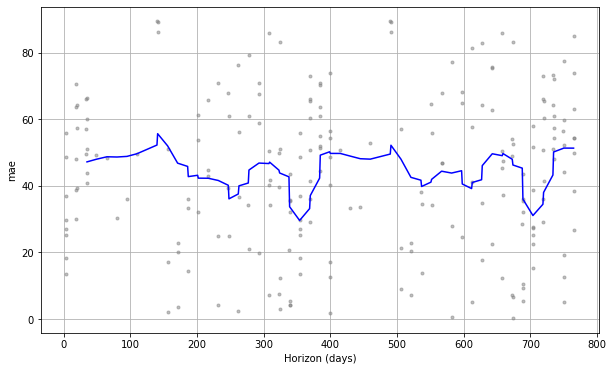

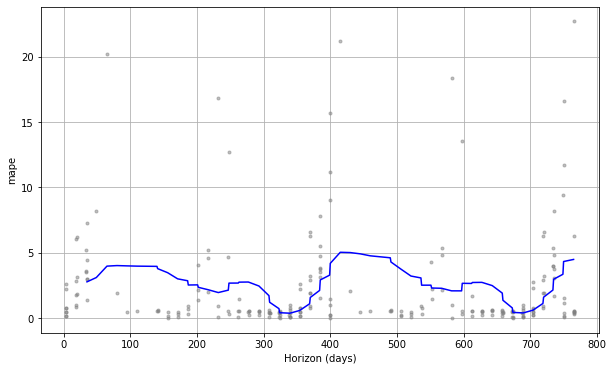

In [133]:
plt_mse = plot_cross_validation_metric(df_20_yearly_cv, metric='mse')

plt_rmse = plot_cross_validation_metric(df_20_yearly_cv, metric='rmse')

plt_mae = plot_cross_validation_metric(df_20_yearly_cv, metric='mae')

plt_mape = plot_cross_validation_metric(df_20_yearly_cv, metric='mape')

In [134]:
r2_20_yearly= r2_score(df_20_yearly_cv['y'], df_20_yearly_cv['yhat'])
print("R2 Square :")
r2_20_yearly

R2 Square :


-0.19147775062724315

# Logistic Model

In [152]:
cap = 250
floor = -100
df_yearly_without_outlier['cap'] = cap
df_yearly_without_outlier['floor'] = floor
m_logistic = Prophet(daily_seasonality = False, yearly_seasonality = True, weekly_seasonality = False,
            seasonality_mode = 'additive',
            growth = 'logistic',
            n_changepoints = 25,
            interval_width = 1.0,
            changepoint_range = 0.8,
            changepoint_prior_scale = 20.0,
            seasonality_prior_scale= 20.0 )

m_logistic.fit(df_yearly_without_outlier)

## 10 year forecast

In [153]:
future_10 = m_logistic.make_future_dataframe(periods=10, freq='y', include_history = True)
future_10['cap'] = cap
future_10['floor'] = floor
forecast_10= m_logistic.predict(future_10)
forecast_10[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
#fig = m.plot(forecast_10)

,ds,yhat,yhat_lower,yhat_upper
241,2025-12-31,53.790237,-73.987389,221.140962
242,2026-12-31,57.972589,-66.261555,181.571091
243,2027-12-31,62.694476,-58.943166,198.570413
244,2028-12-31,47.494350,-115.580289,200.723629
245,2029-12-31,51.134092,-89.282104,189.065457


In [154]:
def seasonality(df, future, name, period, fourier_order):
    model = Prophet(weekly_seasonality=False)
    model.add_seasonality(name=name, period=period, fourier_order=fourier_order)
    forecast = model.fit(df).predict(future)
    fig = model.plot_components(forecast)

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


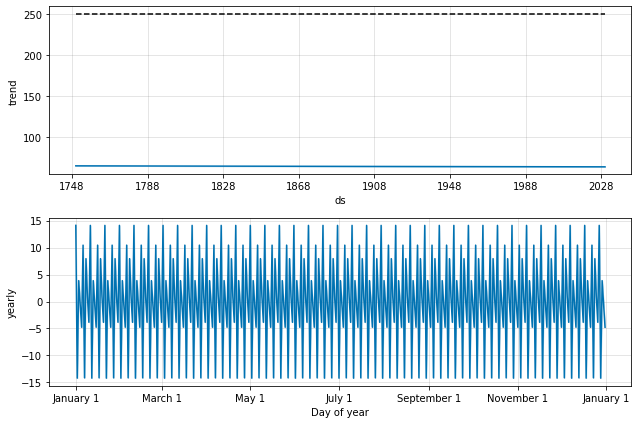

In [155]:
seasonality(df_yearly_without_outlier, future_10, 'yearly', 10, 4)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


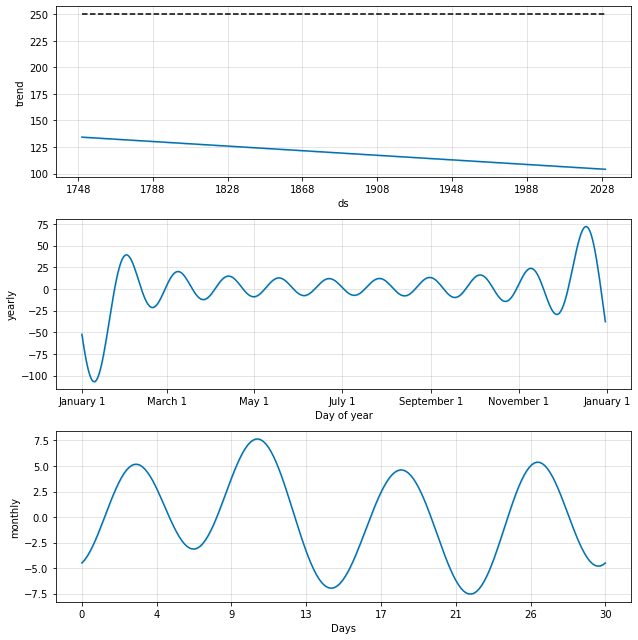

In [156]:
seasonality(df_yearly_without_outlier, future_10, 'monthly', 30, 5)

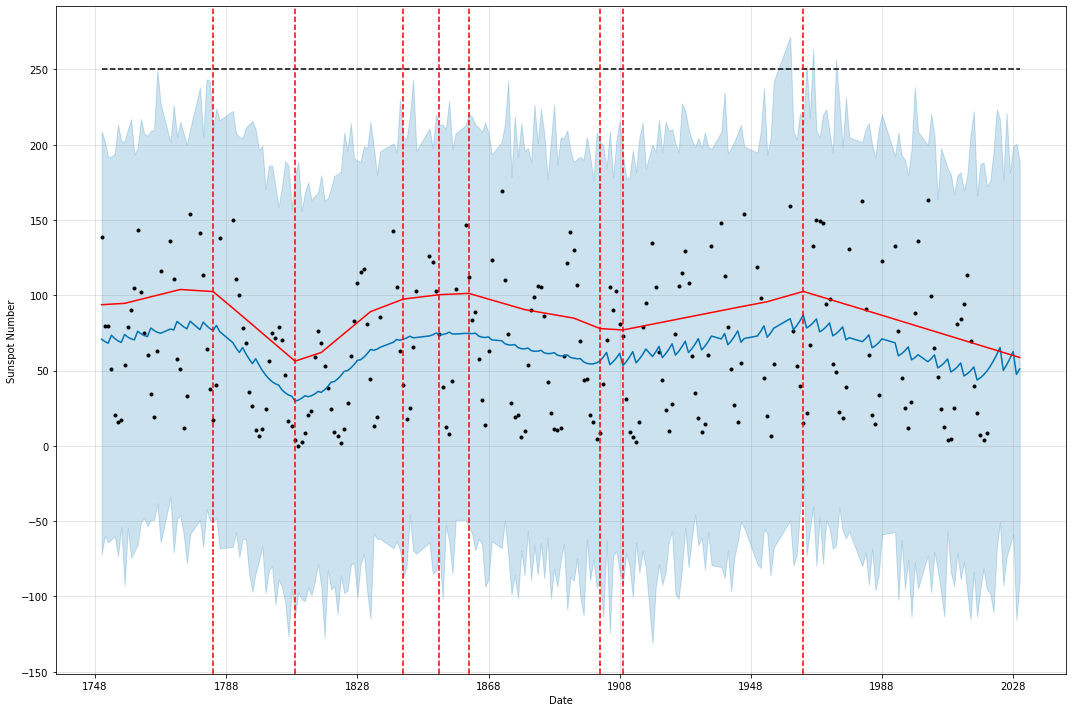

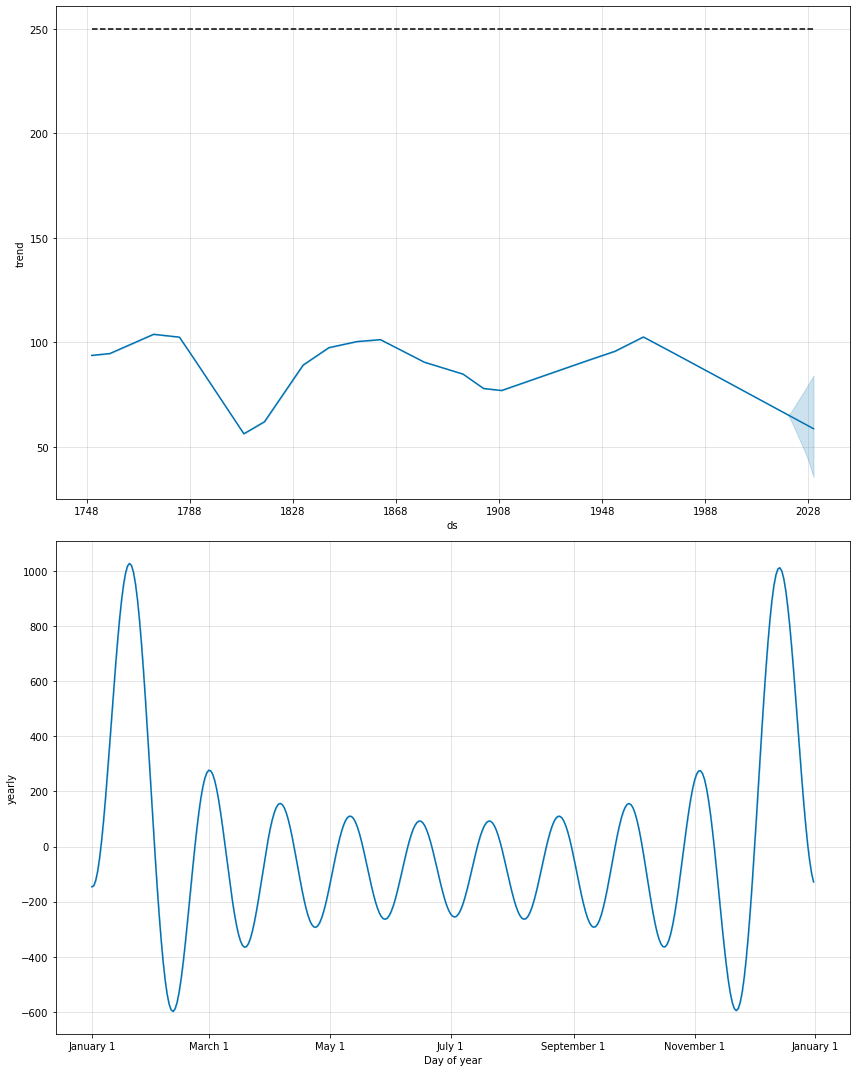

In [157]:
fig = model.plot(forecast_10, xlabel = "Date", ylabel = "Sunspot Number", figsize = (15,10))
a= add_changepoints_to_plot(fig.gca(),model,forecast_10)
fig1=model.plot_components(forecast_10, figsize=(12,15))

### Cross Validation and Performance Metrics

In [158]:
df_yearly_logistic_cv = cross_validation(m_logistic, initial='75000 days', period='100 days', horizon = '365 days', parallel = 'processes')

INFO:prophet:Making 180 forecasts with cutoffs between 1959-03-17 00:00:00 and 2019-01-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb0af7b3b20>


In [159]:
df_yearly_logistic_perf = performance_metrics(df_yearly_logistic_cv)
df_yearly_logistic_perf.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,39 days,1971.081994,44.396869,38.639067,1.623757,0.682726,0.692551,1.0
1,43 days,2083.118204,45.641190,39.924451,1.593461,0.575757,0.692077,1.0
2,47 days,2279.545164,47.744583,42.266583,1.610753,0.575757,0.717133,1.0
3,48 days,2354.682746,48.525073,43.049636,2.223424,0.682726,0.780816,1.0
4,51 days,2216.220572,47.076752,42.110157,2.434613,0.986882,0.815030,1.0


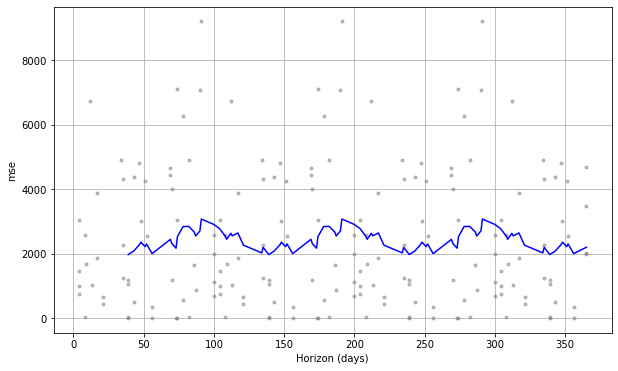

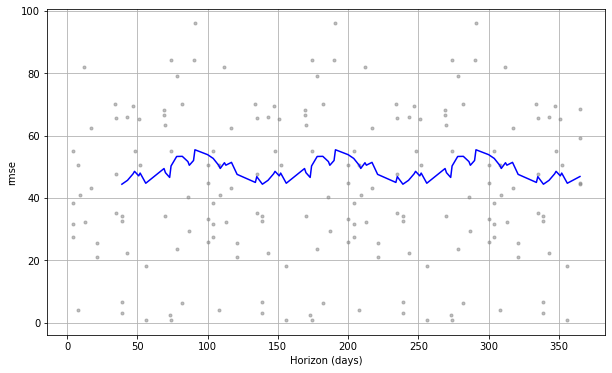

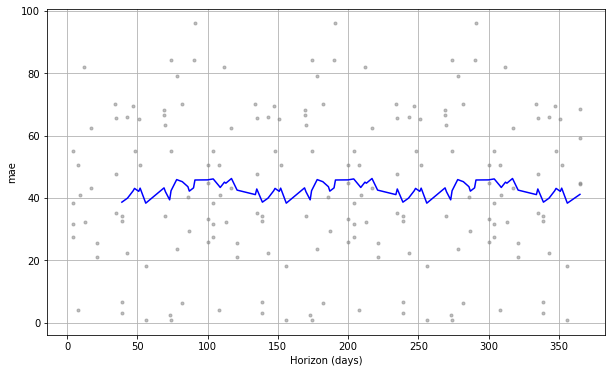

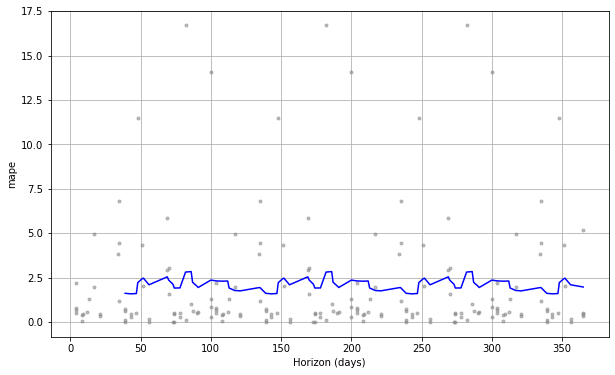

In [160]:
plt_mse = plot_cross_validation_metric(df_yearly_logistic_cv, metric='mse')

plt_rmse = plot_cross_validation_metric(df_yearly_logistic_cv, metric='rmse')

plt_mae = plot_cross_validation_metric(df_yearly_logistic_cv, metric='mae')

plt_mape = plot_cross_validation_metric(df_yearly_logistic_cv, metric='mape')

In [161]:
r2_yearly_logistic= r2_score(df_yearly_logistic_cv['y'], df_yearly_logistic_cv['yhat'])
print('R2 Score :')
r2_yearly_logistic

R2 Score :


-0.07549586274315456

## 20 year forecast

In [145]:
future_20 = m_logistic.make_future_dataframe(periods=20, freq='y', include_history = True)
future_20['cap'] = cap
future_20['floor'] = floor
forecast_20= m_logistic.predict(future_10)
forecast_20[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
241,2025-12-31,64.288364,-105.588983,233.378000
242,2026-12-31,64.480159,-105.748474,233.676925
243,2027-12-31,64.745150,-63.472289,190.778454
244,2028-12-31,64.216322,-87.235587,184.782986
245,2029-12-31,64.334404,-72.054045,192.230850


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


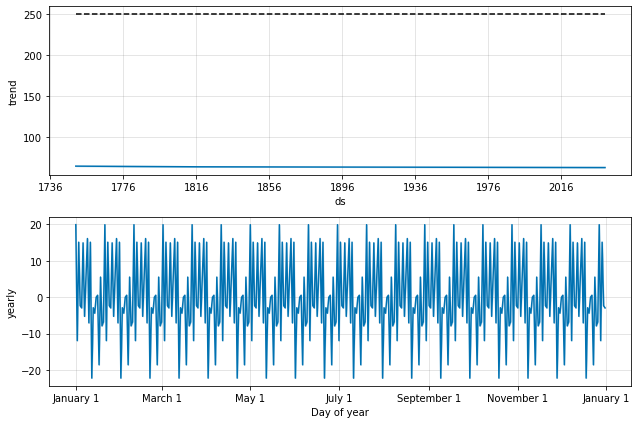

In [146]:
seasonality(df_yearly_without_outlier, future_20, 'yearly', 20, 10)

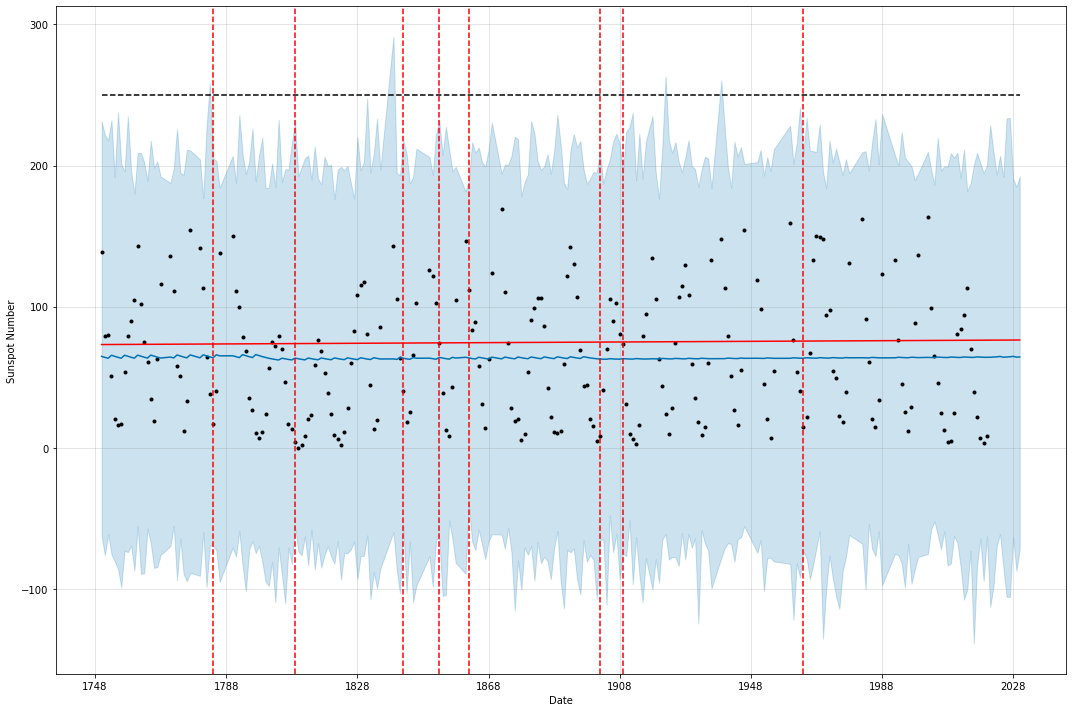

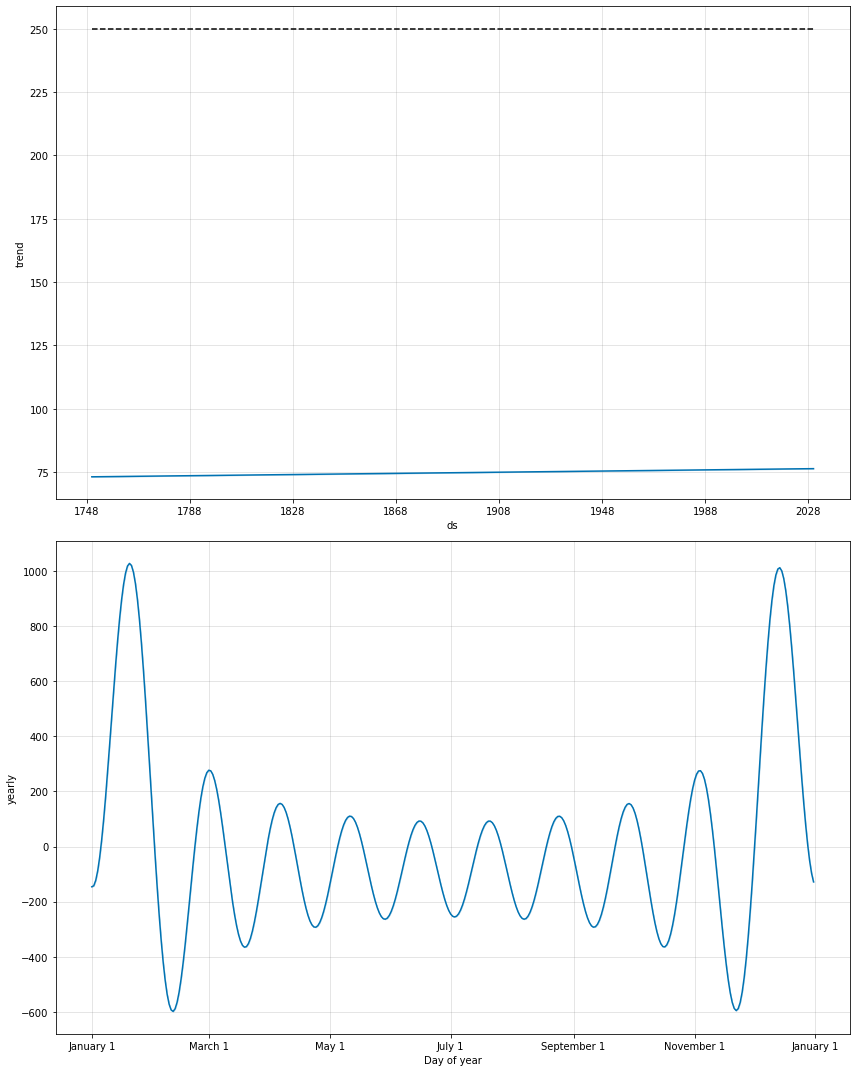

In [147]:
fig = model.plot(forecast_20, xlabel = "Date", ylabel = "Sunspot Number", figsize = (15,10))
a= add_changepoints_to_plot(fig.gca(),model,forecast_10)
fig1=model.plot_components(forecast_20, figsize=(12,15))

### Cross validation and performance metrics

In [148]:
df_yearly_logistic20_cv = cross_validation(m_logistic, initial='95000 days', period='120 days', horizon = '365 days', parallel = 'processes')

INFO:prophet:Making 28 forecasts with cutoffs between 2010-02-17 00:00:00 and 2019-01-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb0b0948340>


In [149]:
df_yearly_logistic20_perf = performance_metrics(df_yearly_logistic20_cv)
df_yearly_logistic20_perf.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,83 days,202.756515,14.239260,14.235082,0.172226,0.172226,0.188455,1.0
1,89 days,396.421912,19.910347,19.334363,0.214404,0.214404,0.241380,1.0
2,94 days,1506.477145,38.813363,36.705514,0.345794,0.345794,0.425183,1.0
3,99 days,1262.974900,35.538358,29.489797,0.286841,0.286841,0.352540,1.0
4,104 days,418.731610,20.462933,18.468672,0.411892,0.411892,0.329560,1.0


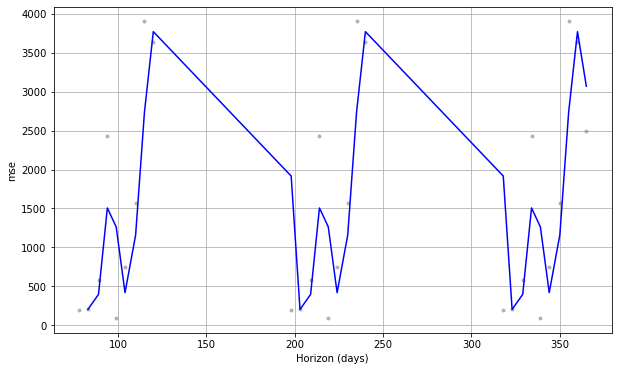

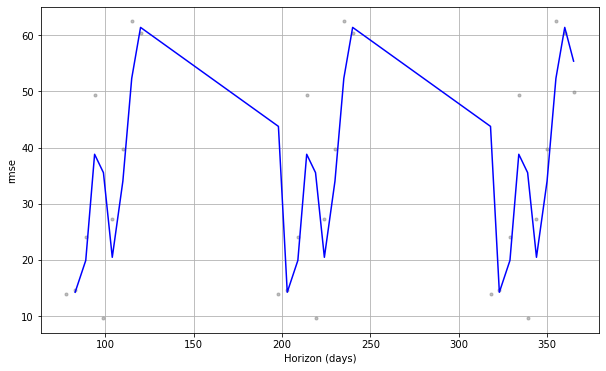

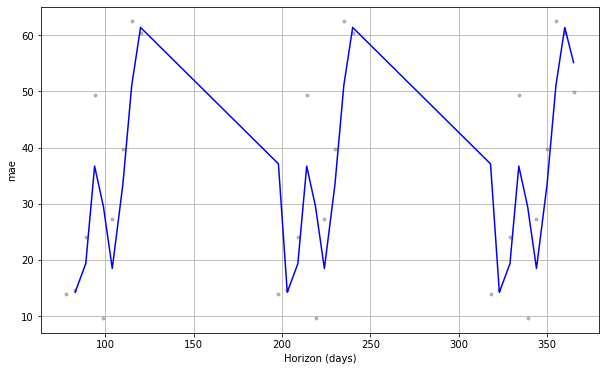

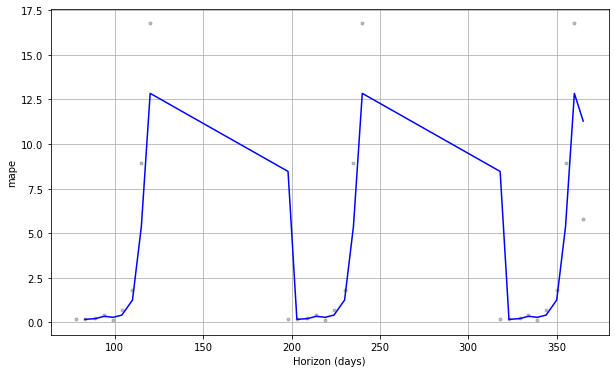

In [150]:
plt_mse = plot_cross_validation_metric(df_yearly_logistic20_cv, metric='mse')

plt_rmse = plot_cross_validation_metric(df_yearly_logistic20_cv, metric='rmse')

plt_mae = plot_cross_validation_metric(df_yearly_logistic20_cv, metric='mae')

plt_mape = plot_cross_validation_metric(df_yearly_logistic20_cv, metric='mape')

In [151]:
r2_yearly_logistic20= r2_score(df_yearly_logistic20_cv['y'], df_yearly_logistic20_cv['yhat'])
print("R2 Square:")
print(r2_yearly_logistic20)

R2 Square:
-0.03862865409199179
